In [77]:
# Data science packages
import pandas as pd 

# Chemoinformatics packages
from rdkit import Chem
from rdkit.Chem import PeriodicTable

# Graph neural netowrks packages
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.data import DataLoader

## Feature vectors

In [34]:
def oneHotEncoding(x, values):
    """
    Helper function to encode the given value as a one-hot vector

    :param x: value to encode
    :param values: encoding vector, i.e. contains every possible values of x
    """

    return [int(x == value) for value in values]

In [32]:
def getAtomFeatureVector(atom):

    # Setup one-hot encoding vectors
    atoms = ["B", "C", "N", "O", "F", "Si", "P", "S", "As", "Se", "Br", "Te", "I", "At"]
    degrees = list(range(6))
    hybridizations = ["sp", "sp2", "sp3", "sp3d", "sp3d2", "other"]
    hydrogens = list(range(5))
    chirality_types = ["R", "S"]
    
#     atom_encoding = [
#         [*[0]*(len(atoms)-1) + [1]] 
#         if atom.IsMetal()
#         else oneHotEncoding(atom.GetSymbol(), atoms)
#     ]

    return [
        *oneHotEncoding(atom.GetSymbol(), atoms),
        *oneHotEncoding(atom.GetDegree(), degrees),
        atom.GetFormalCharge(),
        *oneHotEncoding(atom.GetHybridization(), hybridizations),
        *oneHotEncoding(atom.GetTotalNumHs(), hydrogens),
        int(atom.GetChiralTag()),
        *oneHotEncoding(atom.GetChiralTag(), chirality_types)
    ]

In [45]:
def getBondFeatureVecotr(bond):
    
    # Setup one-hot encoding vectors
    bond_types = ["single", "double", "triple", "aromatic"]
    stereo_types = ["StereoNone", "StereoAny", "StereoZ", "StereoE"]
    
    return [
        *oneHotEncoding(bond.GetBondType(), bond_types),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        *oneHotEncoding(bond.GetStereo(), stereo_types)
    ]

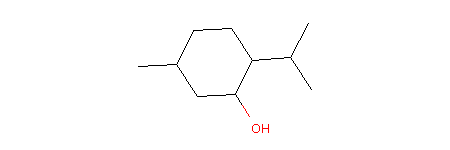

In [26]:
mol = Chem.MolFromSmiles("CC1CCC(C(C1)O)C(C)C")
mol

## Relational graph neural network (RGCN)

The GNN architecture used to predict the solubility of molecules is a relational GNN. A RGNN model extends a standard GCN model by also using edge types in the node update function,

$$
h_v^{(l+1)} = ReLU\left(\sum_{r \in R} \sum_{u \in N_v^r} W_r^{(l)} h_u^{(l)} + W_0^{(l)} h_v^{(l)}\right),
$$

with $R$ the set of edge types and $W_r^{(l)}$ a weight matrix of edge type $r$ of layer $l$ with learnable 
parameters and $N_v^r$ is the set of neighboring atoms with edge type $r$.

In [ ]:
class MLP(torch.nn.Module):
    
    def __init__(self, input_units, hidden_units):
        super().__init__()
        
        self.lin1 = Linear(input_units, hidden_units)
        self.lin2 = Linear(hidden_units, hidden_units)
        self.lin3 = Linear(hidden_units, dataset.num_classes)
        
    def forward(self, x):
        
        h = self.lin1(x)
        h = F.relu(h)
        h = F.dropout(0.1)
        
        h = self.lin2(h)
        h = F.relu(h)
        h = F.dropout(0.1)
        
        h = self.lin3(h)
        h = F.relu(h)
        
        return h


In [60]:
class MolecularEmbedding(torch.nn.Module):
    
    def __init__(self, input_units):
        super().__init()
        
        self.lin1 = Linear(input_units, dataset.num_nodes)
        
    def forward(self, x):
        
        # Compute weights for each node
        omega = self.lin1(x)
        omega = F.sigmoid(omega)
        
        # Compute molecular embedding by a weighted sum
        return omega @ x

In [61]:
class RGCN(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Define layers
        self.rgcn1 = RGCNConv(dataset.num_node_features, 256, 64)
        self.rgcn2 = RGCNConv(256, 256, 64)
        self.molecularEmbedding = MolecularEmbedding(256)
        self.mlp = MLP(256, 64)
        
    def forward(self, x, edge_index):
        
        # Pass through two RGCN layers
        h = self.rgcn1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(0.5, learning=self.training)
        
        h = self.rgcn2(h, edge_index)
        h = F.relu(h)
        h = F.dropout(0.5, learning=self.training)
        
        # Create molecular embedding
        molecular_embedding = self.molecularEmbedding(h)
        
        # Pass through a three layer MLP to obtain prediction
        y = self.mlp(molecular_embedding)
        
        return y

## Training RGCN

In [62]:
data = pd.read_csv("../data/ESOL.csv")
data.head()

,smiles,ESOL,group
0,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,-0.77,training
1,Cc1occc1C(=O)Nc1ccccc1,-3.30,training
2,CC(C)=CCCC(C)=CC=O,-2.06,training
3,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,training
4,c1ccsc1,-1.33,training


In [70]:
train_data = data.query("group == 'training'")
test_data = data.query("group == 'test'")
val_data = data.query("group == 'valid'")

In [74]:
train_data.shape

(888, 3)

In [75]:
test_data.shape

(112, 3)

In [76]:
val_data.shape

(111, 3)

In [ ]:
train_dataloader = DataLoader(train_data)